### Usage:
 - if no CSV statement available directly, convert HSBC bank account PDF statements to CSV (for example using tabula)
 - from HSBC bank account PDF extract with tabula: date, payment type and details, paid-in, paid-out (do not use balance); refer to example.csv file
 - use at your own risk

### Imports

In [1]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
pd.options.display.max_rows = 999

### Functions

In [2]:
def merge_on_nan_debit_entries(bk):
    '''This function copies debit values in cells
    with nan values above them'''
    index_list = bk.index[bk.iloc[:,3].isnull() & bk.iloc[:,4].isnull()].to_list()
    for item in index_list:
        first_part = bk.iloc[item, 2]
        second_part = bk.iloc[item + 1, 2]
        #print(first_part + " " + second_part)
        bk.iloc[item, 2] = str(first_part) + " " + str(second_part)   
        money_part = bk.iloc[item + 1, 3]
        bk.iloc[item, 3] = money_part

### Read in data

In [3]:
bk = pd.read_csv("example.csv", header=None)
bk.head(10)

,0,1,2,3,4
0,03-Jan-21,BP,Savings,10.0,NaN
1,NaN,NaN,123456,NaN,NaN
2,04-Jan-21,DD,Landlord,100.0,NaN
3,NaN,VIS,Grocerystore,NaN,NaN
4,NaN,NaN,NaN,2.5,NaN
5,NaN,VIS,Petrolstation,NaN,NaN
6,NaN,NaN,Example,1.0,NaN
7,NaN,VIS,Gassupplier,NaN,NaN
8,NaN,NaN,NaN,2.0,NaN
9,NaN,VIS,Foodshop,NaN,NaN


### Format data for analysis

In [4]:
#name dataframe columns
bk.columns = ["Date", "Type", "Description", "Debit", "Credit"]

#### Handle Debit and Credit entries with Description details across multiple lines in csv file
 - for Debits a function will automatically clear up as many times as necessary
 - for Credits it is only cleared up once and might need to improve further; this might break if a Credit Description line spans more than two lines

In [5]:
#create index list of entries that do not contain NaN in column 4 ("Credit") and
#have a NaN entry in column 3 ("Debit")
#for these indices run the below for-loop which will copy entries as per below

index_list = bk.index[bk.iloc[:,3].isnull() & bk.iloc[:,4].notnull()].to_list()
for item in index_list:
    first_part = bk.iloc[item - 1, 2]
    second_part = bk.iloc[item, 2]
    #print(first_part + " " + second_part)
    bk.iloc[item -1, 2] = str(first_part) + " " + str(second_part)   
    money_part = bk.iloc[item, 4]
    bk.iloc[item -1, 4] = money_part

In [6]:
#check if NaN in Debit column after function calls

#create index list of entries that contain NaN in column 3 ("Debit")
index_listing = bk.index[bk.iloc[:,3].isnull() & bk.iloc[:,4].isnull()].to_list()

#for-loop to check if merge_on_nan_entries function needs to be run again
#once index_listing_loop is empty (no more NaN entries in Debit column in bk)
#break out of for-loop
for item in range(len(index_listing)):
    index_listing_loop = bk.index[bk.iloc[:,3].isnull() & bk.iloc[:,4].isnull()].to_list()
    if len(index_listing_loop) > 0:
        merge_on_nan_debit_entries(bk)
        #print(len(index_listing_loop))
    else:
        break
        
#ensure that CSV file does not contain blank line, otherwise this will throw an IndexError

##### Run tests to see if Debit and Credit was handled correctly

In [7]:
#check if Debit and Credit properly cleared with above codes/measures
#if check_entries and check_entries_two are empty lists, it should be clear, otherwise needs to examine if
#credit entries span more than two lines at Description column
check_entries = bk.index[bk.iloc[:,3].notnull() & bk.iloc[:,4].notnull()].to_list()
check_entries_two = bk.index[bk.iloc[:,3].isnull() & bk.iloc[:,4].isnull()].to_list()
print(check_entries)
print(check_entries_two)
if check_entries_two:
    for entry in check_entries_two:
        print(bk.loc[entry, ["Date", "Type", "Description"]])

[]
[]


In [8]:
bk_one = bk[bk['Type'].notna()]

#### Convert date/datetime and fill in values in missing rows, create new columns with year and month

In [9]:
#copy values in below row if empty (populate date column)
bk_one["Date"] = bk.iloc[:,0].fillna(method='ffill')
bk_one['Date'] = pd.to_datetime(bk_one['Date'], dayfirst=True)
bk_one.sort_values(by=['Date'], inplace=True, ascending=False)

In [10]:
bk_one["Date"]= pd.to_datetime(bk_one["Date"], dayfirst=True) 
bk_one['Year'] = bk_one['Date'].dt.year
bk_one['Month'] = bk_one['Date'].dt.month

In [11]:
bk_one.head(10)

,Date,Type,Description,Debit,Credit,Year,Month
47,2021-03-10,CR,Employer Example,NaN,200.0,2021,3
45,2021-03-05,VIS,Netflix Example,12.0,NaN,2021,3
43,2021-03-05,VIS,Council City,10.0,NaN,2021,3
41,2021-03-04,VIS,Foodshop ONLINE,23.0,NaN,2021,3
39,2021-03-04,VIS,Electricity INTERNET,5.0,NaN,2021,3
37,2021-03-04,VIS,Petrolstation Example,25.0,NaN,2021,3
35,2021-03-04,VIS,Grocerystore Example,10.0,NaN,2021,3
34,2021-03-04,DD,Landlord,54.0,NaN,2021,3
32,2021-03-03,BP,Savings,5.0,NaN,2021,3
30,2021-02-10,CR,Employer Example,NaN,250.0,2021,2


#### Convert columns 1, 3 and 4 to strings and replace nan with empty strings

In [12]:
bk_one.iloc[:,1] = bk_one.iloc[:,1].astype(str)
bk_one.iloc[:,3] = bk_one.iloc[:,3].astype(str)
bk_one.iloc[:,4] = bk_one.iloc[:,4].astype(str)
bk_one.iloc[:,3] = bk_one.iloc[:,3].str.replace(",", "")
#bk.iloc[:,3] = bk.iloc[:,3].astype(float)

bk_one.iloc[:,3] = bk_one.iloc[:,3].str.replace("nan", "")
bk_one.iloc[:,4] = bk_one.iloc[:,4].str.replace("nan", "")

#### String formatting in columns Debit, Credit and Description

In [13]:
bk_one["Debit"] = bk_one["Debit"].str.replace(",", "")
bk_one["Credit"] = bk_one["Credit"].str.replace(",", "")
bk_one["Description"] = bk_one["Description"].str.replace("H\*G", "H3G")
bk_one["Description"] = bk_one["Description"].str.replace("*", "")
bk_one['Description'] = bk_one['Description'].astype(str)
bk_one['Description'] = bk_one['Description'].map(lambda element: " ".join(element.split()))
bk_one['Description'] = bk_one['Description'].str.upper()

#### Coerce Debit and Credit column to float for calculations

In [14]:
bk_one['Debit'] = pd.to_numeric(bk_one['Debit'])
bk_one["Credit"] = pd.to_numeric(bk_one["Credit"])

#### Intermediate check on dataframe bk_one

In [15]:
bk_one.head(10)

,Date,Type,Description,Debit,Credit,Year,Month
47,2021-03-10,CR,EMPLOYER EXAMPLE,NaN,200.0,2021,3
45,2021-03-05,VIS,NETFLIX EXAMPLE,12.0,NaN,2021,3
43,2021-03-05,VIS,COUNCIL CITY,10.0,NaN,2021,3
41,2021-03-04,VIS,FOODSHOP ONLINE,23.0,NaN,2021,3
39,2021-03-04,VIS,ELECTRICITY INTERNET,5.0,NaN,2021,3
37,2021-03-04,VIS,PETROLSTATION EXAMPLE,25.0,NaN,2021,3
35,2021-03-04,VIS,GROCERYSTORE EXAMPLE,10.0,NaN,2021,3
34,2021-03-04,DD,LANDLORD,54.0,NaN,2021,3
32,2021-03-03,BP,SAVINGS,5.0,NaN,2021,3
30,2021-02-10,CR,EMPLOYER EXAMPLE,NaN,250.0,2021,2


#### Drop all rows with nan values in column 1 (none should be there, but just in case), reset index

In [16]:
bk_one = bk_one[~bk_one.iloc[:,1].str.contains("nan")]
bk_one = bk_one.reset_index(drop=True)

### Analysis

#### Categorise the transactions
##### Transactions described in column "Description" are categorized according to definitions below. The below categories are examples only - tweak and setup as required. 

In [17]:
#create labels and categories as required
#_list_pattern contains dummy entries, change as required
#categorise items based on column bk_one["Description"]

# label items as grocery category
grocery_list_pattern = ["FOODSH", "GROCERYSTO"]
grocery_pattern = '|'.join(grocery_list_pattern)
grocery_mask = bk_one["Description"].str.contains(grocery_pattern)
bk_one.loc[grocery_mask, 'Category'] = "Grocery"

# label items as rent category
rent_list_pattern = ["LANDLORD"]
rent_pattern = '|'.join(rent_list_pattern)
rent_mask = bk_one["Description"].str.contains(rent_pattern)
bk_one.loc[rent_mask, 'Category'] = "Rent"

# label items as council tax category
counciltax_list_pattern = ["COUNCIL"]
counciltax_pattern = '|'.join(counciltax_list_pattern)
counciltax_mask = bk_one["Description"].str.contains(counciltax_pattern)
bk_one.loc[counciltax_mask, 'Category'] = "Council tax"

# label items as Internet/Phone category
inter_phone_list_pattern = ["PHONE"]
inter_phone_pattern = '|'.join(inter_phone_list_pattern)
inter_phone_mask = bk_one["Description"].str.contains(inter_phone_pattern)
bk_one.loc[inter_phone_mask, 'Category'] = "Internet/Phone"

# label items as other category
other_list_pattern = ["OTHER"] 
other_pattern = '|'.join(other_list_pattern)
other_mask = bk_one["Description"].str.contains(other_pattern)
bk_one.loc[other_mask, 'Category'] = "Other"

# label items as streaming service category
stream_list_pattern = ["NETFLIX"]
stream_pattern = '|'.join(stream_list_pattern)
stream_mask = bk_one["Description"].str.contains(stream_pattern)
bk_one.loc[stream_mask, 'Category'] = "Streaming Service"

# label items as clothes category
clothes_list_pattern = ["CLOTHES"]
clothes_pattern = '|'.join(clothes_list_pattern)
clothes_mask = bk_one["Description"].str.contains(clothes_pattern)
bk_one.loc[clothes_mask, 'Category'] = "Clothes"

# label items as takeaway/eat out service category
takeaway_list_pattern = ["STARBUCKS"]
takeaway_pattern = '|'.join(takeaway_list_pattern)
takeaway_mask = bk_one["Description"].str.contains(takeaway_pattern)
bk_one.loc[takeaway_mask, 'Category'] = "Takeaway/Eat-out"

# label items as cash withdrawal service category
cash_list_pattern = ["CASH"]
cash_pattern = '|'.join(cash_list_pattern)
cash_mask = bk_one["Description"].str.contains(cash_pattern)
bk_one.loc[cash_mask, 'Category'] = "Cash ATM"

# label items as car w/o petrol service category
car_list_pattern = ["MOT", "CAR INSURANCE"]
car_pattern = '|'.join(car_list_pattern)
car_mask = bk_one["Description"].str.contains(car_pattern)
bk_one.loc[car_mask, 'Category'] = "Car w/o petrol"

# label items as petrol service category
petrol_list_pattern = ["PETROLSTATION"]
petrol_pattern = '|'.join(petrol_list_pattern)
petrol_mask = bk_one["Description"].str.contains(petrol_pattern)
bk_one.loc[petrol_mask, 'Category'] = "Petrol"

# label items as healthcare service category
healthcare_list_pattern = ["DENTIST"]
healthcare_pattern = '|'.join(healthcare_list_pattern)
healthcare_mask = bk_one["Description"].str.contains(healthcare_pattern)
bk_one.loc[healthcare_mask, 'Category'] = "Healthcare"

# label items as water utility
water_util_list_pattern = ["WATERSUPPLIER"]
water_util_pattern = '|'.join(water_util_list_pattern)
water_util_mask = bk_one["Description"].str.contains(water_util_pattern)
bk_one.loc[water_util_mask, 'Category'] = "Water utility bill"

# label items as electricity and gas utility
elec_gas_util_list_pattern = ["GASSUP", "ELECTRICITYSUP"]
elec_gas_util_pattern = '|'.join(elec_gas_util_list_pattern)
elec_gas_util_mask = bk_one["Description"].str.contains(elec_gas_util_pattern)
bk_one.loc[elec_gas_util_mask, 'Category'] = "Electricity and Gas utility bill"

# label items as credit card utility
creditcard_list_pattern = ["CREDIT CARD"]
creditcard_pattern = '|'.join(creditcard_list_pattern)
creditcard_mask = bk_one["Description"].str.contains(creditcard_pattern)
bk_one.loc[creditcard_mask, 'Category'] = "Credit Card"

# fill Description savings
sav_mask = (((bk_one["Type"] == "BP") | (bk_one["Type"] == "OBP")) & (bk_one["Debit"] > 100.0)) | (bk_one["Description"].str.contains("SAVINGS"))
bk_one.loc[sav_mask, 'Description'] = "SAVINGS"
bk_one.loc[sav_mask, 'Category'] = "Savings"

# fill Description Salary/Expense refunds 
salary_mask = ((bk_one["Type"] == "CR") & (bk_one["Credit"] > 200.0)) | (bk_one["Description"].str.contains("EMPLOYER"))
bk_one.loc[salary_mask, 'Description'] = "SALARY"
bk_one.loc[salary_mask, 'Category'] = "Salary/Expense refunds"

##### Check if all expenses have a category; if nothing shown here, all transactions have a category allocated to it, otherwise respective entries will be shown here

In [18]:
#check if any entries in Category are NaN; if so aim to categorise these
#if nothing shown no entries found
bk_one[bk_one["Category"].isnull()]
#len(bk_one[bk_one["Category"].isnull()])

,Date,Type,Description,Debit,Credit,Year,Month,Category


#### High level analysis focus on 2021
 - show expenses according to category
 - show monthly spending 
 - savings
 - total_expenses
 - salary

#### Show overall expenses according to category, including savings and monthly breakdown

In [19]:
#specify year to analyse. if all years taken into account simply 
#assign entire bk_one df to bk_one_2021 instead of bk_one[bk_one["Year"] == 2021]
bk_one_2021 = bk_one[bk_one["Year"] == 2021]
ov_expense = bk_one_2021.groupby(["Category"])["Debit"].sum()
print("Overall expense for 2021 for respective category: \n")
print(ov_expense)

Overall expense for 2021 for respective category: 

Category
Electricity and Gas utility bill      7.0
Healthcare                            6.0
Petrol                               51.0
Salary/Expense refunds                0.0
Savings                              20.0
Streaming Service                    12.0
Work                                323.5
Name: Debit, dtype: float64


In [20]:
#monthly breakdown
ov_expense_monthly_bd = bk_one_2021.groupby(["Month","Category"])["Debit"].sum()
print("Overall monthly expense for 2021 for respective category: \n")
print(ov_expense_monthly_bd.reset_index())

Overall monthly expense for 2021 for respective category: 

    Month                          Category  Debit
0       1  Electricity and Gas utility bill    2.0
1       1                            Petrol    1.0
2       1            Salary/Expense refunds    0.0
3       1                           Savings   10.0
4       1                              Work  108.5
5       2  Electricity and Gas utility bill    5.0
6       2                        Healthcare    6.0
7       2                            Petrol   25.0
8       2            Salary/Expense refunds    0.0
9       2                           Savings    5.0
10      2                              Work  113.0
11      3                            Petrol   25.0
12      3            Salary/Expense refunds    0.0
13      3                           Savings    5.0
14      3                 Streaming Service   12.0
15      3                              Work  102.0


#### Show monthly spending (including any deductions from account for savings)

In [21]:
spending_monthly_grouped_month = bk_one_2021.groupby(["Month", "Year"])["Debit"].sum()
spending_monthly_grouped_month

Month  Year
1      2021    121.5
2      2021    154.0
3      2021    144.0
Name: Debit, dtype: float64

#### Salary dataframe, total salary and monthly breakdown

In [22]:
bk_salary_index = bk_one_2021["Description"].str.contains("SALARY")
salary_df = bk_one_2021.loc[bk_salary_index]
#salary_df

In [23]:
total_salary = salary_df["Credit"].sum().round(2)
print("Total salary:")
print(total_salary)

Total salary:
700.0


In [24]:
salary_df_grouped_month = salary_df.groupby(["Month", "Year"])["Credit"].sum()
salary_df_grouped_month

Month  Year
1      2021    250.0
2      2021    250.0
3      2021    200.0
Name: Credit, dtype: float64

#### Savings total_amount and monthly basis

In [25]:
bk_one_savings_index_2021 = bk_one_2021["Description"].str.contains("SAVINGS")
savings_df = bk_one_2021.loc[bk_one_savings_index_2021]
savings_amount = savings_df.iloc[:,3].sum()
print("Total savings transfered:")
print(savings_amount)

print("Savings transfered monthly breakdown:")
savings_df_grouped_month = savings_df.groupby(["Month", "Year"])["Debit"].sum()
print(savings_df_grouped_month)

#savings_df

Total savings transfered:
20.0
Savings transfered monthly breakdown:
Month  Year
1      2021    10.0
2      2021     5.0
3      2021     5.0
Name: Debit, dtype: float64


#### Living expenses calculated as total_expenses from account minus savings_amount

In [26]:
total_expenses = bk_one_2021["Debit"].sum()
expenses_2021 = total_expenses - savings_amount
print("Expenses other than savings for 2021,")
print("calculated as total expenses - savings_amount")
print(expenses_2021.round(2))

Expenses other than savings for 2021,
calculated as total expenses - savings_amount
399.5


#### Summary of monthly_grouped data 
 - spending 
 - salary
 - savings

In [27]:
print(spending_monthly_grouped_month)
print(salary_df_grouped_month)
print(savings_df_grouped_month)

Month  Year
1      2021    121.5
2      2021    154.0
3      2021    144.0
Name: Debit, dtype: float64
Month  Year
1      2021    250.0
2      2021    250.0
3      2021    200.0
Name: Credit, dtype: float64
Month  Year
1      2021    10.0
2      2021     5.0
3      2021     5.0
Name: Debit, dtype: float64


#### Concatenate Series into summary dataframe containing monthly info on:
 - spending
 - salary
 - savings

In [28]:
summary_df = pd.concat([spending_monthly_grouped_month, salary_df_grouped_month, savings_df_grouped_month], axis=1)
summary_df.columns = ["Expense £", "Salary £", "Savings £"]

In [29]:
#fill every NaN with 0 for calculation purposes
summary_df = summary_df.fillna(0)

In [30]:
#calculate living expenses as per below and attach column
summary_df["Living Expense £"] = summary_df["Expense £"] - summary_df["Savings £"]
#summary_df

In [31]:
#make index to columns; i.e., turn index month and year into columns
sum_df = summary_df.reset_index()
sum_df

,Month,Year,Expense £,Salary £,Savings £,Living Expense £
0,1,2021,121.5,250.0,10.0,111.5
1,2,2021,154.0,250.0,5.0,149.0
2,3,2021,144.0,200.0,5.0,139.0


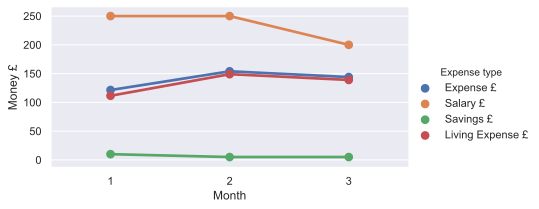

In [32]:
sum_df_melt = sum_df.melt(['Month', 'Year'], var_name='Expense type',  value_name='Money £')
g = sns.catplot(x='Month', y="Money £", hue='Expense type', data=sum_df_melt, kind='point', height=3, aspect=2)

#### Visual examination/summary of changes in spending categories over months

In [33]:
#create dataframe out respective series (to_frame(), and reset_index() to make indices to columns)
sum_cat_month = bk_one_2021.groupby(["Month", "Category"])["Debit"].sum().to_frame().reset_index()
#sum_cat_month

In [34]:
#splitting df sum_cat_month into chunks based on month (categorues can be different depending on month)
sum_cat_drop_month_list = [pd.DataFrame(y) for x, y in sum_cat_month.groupby('Month', as_index=False)]

#check if categories of dfs in list are unique each to check if splitting occured ok
#test ok if return is True, otherwise if False problem occured
for item in sum_cat_drop_month_list:
    print(item["Category"].is_unique)

True
True
True


In [35]:
#set "Category" column as index and concat all dataframes in the list on that index 
sum_cat_drop_month_index = [df.set_index('Category') for df in sum_cat_drop_month_list]
sum_cat_drop_month_index

summary_expense_category_along_months = pd.concat(sum_cat_drop_month_index, axis=1)

#keep columns named Debit and rename those according to month
secam = summary_expense_category_along_months["Debit"]
#rename columns
column_names = []
for i in range(0, secam.shape[1]):
    col_name = "Month_" + str(i+1)
    column_names.append(col_name)
secam.columns = column_names

#transpose the df to swap index and columns - using T attribute; alternative would be transpoase()
secam_t = secam.T
secam_t = secam_t.fillna(0)
secam_t    

,Electricity and Gas utility bill,Petrol,Salary/Expense refunds,Savings,Work,Healthcare,Streaming Service
Month_1,2.0,1.0,0.0,10.0,108.5,0.0,0.0
Month_2,5.0,25.0,0.0,5.0,113.0,6.0,0.0
Month_3,0.0,25.0,0.0,5.0,102.0,0.0,12.0


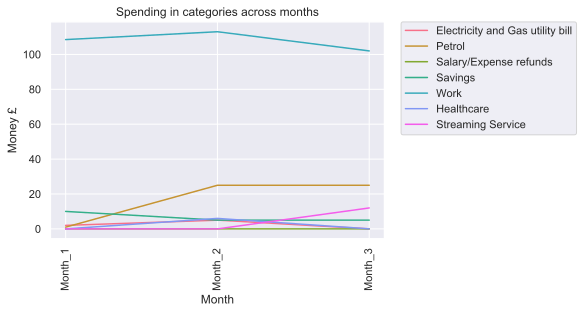

In [36]:
sns.set_palette("husl")
#sns.set_palette("PuBuGn_d")
#filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
#fig = sns.lineplot(data=secam_t, dashes=False, markers = filled_markers)
fig = sns.lineplot(data=secam_t, dashes=False)
plt.xlabel("Month")
plt.xticks(rotation=90)
plt.ylabel("Money £")
plt.title("Spending in categories across months")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show(fig)

In [37]:
#secam_t .mean()